<a href="https://colab.research.google.com/github/Nasim-Amani/Attention-based-seq2seq-/blob/main/MHA_seq2seq_LSTM_24_Hour_Ahead_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)
from keras.models import Model, Sequential
from keras.layers import (Input, TimeDistributed, LSTM, Concatenate,
                          Dense, Dropout, Attention)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

In [ ]:


# Load the data
data = pd.read_csv("metro_all6.csv")
columns_to_keep = ['datetime', 'Load',
                   'Load_previous_hour','Load_same_hour_previous_day',
                   'day_part_encoded',
                   'ALLSKY_SFC_UV_INDEX',
                   'month_sin','month_cos','day_of_week_num_sin' , 'day_of_week_num_cos']
df = data[columns_to_keep]
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Split the data into train, validation, and test sets
total_size = len(df)
train_size = int(total_size * 0.5)
valid_size = int(total_size * 0.2)
test_size = total_size - train_size - valid_size

train = df.iloc[:train_size]
valid = df.iloc[train_size:train_size+valid_size]
test = df.iloc[train_size+valid_size:]

# Create scaler and fit on the training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Load',
                   'Load_previous_hour','Load_same_hour_previous_day',
                   'day_part_encoded',
                   'ALLSKY_SFC_UV_INDEX',
                   'month_sin','month_cos','day_of_week_num_sin' , 'day_of_week_num_cos']])

# Apply the same scaler to the validation and test sets
valid_scaled = scaler.transform(valid[['Load',
                   'Load_previous_hour','Load_same_hour_previous_day',
                   'day_part_encoded',
                   'ALLSKY_SFC_UV_INDEX',
                   'month_sin','month_cos','day_of_week_num_sin' , 'day_of_week_num_cos']])
test_scaled = scaler.transform(test[['Load',
                   'Load_previous_hour','Load_same_hour_previous_day',
                   'day_part_encoded',
                   'ALLSKY_SFC_UV_INDEX',
                   'month_sin','month_cos','day_of_week_num_sin' , 'day_of_week_num_cos']])




def create_seq2seq_data(data, sequence_length, num_prediction_steps):
    X_enc = []
    X_dec = []
    y_dec = []

    for i in range(sequence_length, len(data) - num_prediction_steps):
        # Encoder input
        encoder_start = i - sequence_length
        encoder_end = i
        X_enc.append(data[encoder_start:encoder_end, :])  # Select only the first column

        # Decoder input
        decoder_start = i - sequence_length + 1
        decoder_end = i + 1
        X_dec.append(data[decoder_start:decoder_end, 0:1])  # Select only the first column

        # Decoder output
        dec_out_start = i + 1
        dec_out_end = i + 1 + num_prediction_steps
        y_dec.append(data[dec_out_start:dec_out_end, 0])  # Select only the first column

    return np.array(X_enc), np.array(X_dec), np.array(y_dec)



sequence_length = 24
num_prediction = 24

# Create the sequence data for train, validation, and test sets
X_enc_train, X_dec_train, y_train = create_seq2seq_data(train_scaled, sequence_length, num_prediction)
X_enc_valid, X_dec_valid, y_valid = create_seq2seq_data(valid_scaled, sequence_length, num_prediction)

# Reshape the data to change the second dimension with the third dimension
X_enc_train = np.transpose(X_enc_train, (0, 2, 1))
X_dec_train = np.transpose(X_dec_train, (0, 2, 1))
y_train = np.expand_dims(y_train, axis=2)
y_train = np.transpose(y_train, (0, 2, 1))


X_enc_valid = np.transpose(X_enc_valid, (0, 2, 1))
X_dec_valid = np.transpose(X_dec_valid, (0, 2, 1))
y_valid = np.expand_dims(y_valid, axis=2)
y_valid = np.transpose(y_valid, (0, 2, 1))
# Print the reshaped data shapes
print("Encoder input shape (train):", X_enc_train.shape)
print("Decoder input shape (train):", X_dec_train.shape)
print("Output shape (train):", y_train.shape)
print("Encoder input shape (valid):", X_enc_valid.shape)
print("Decoder input shape (valid):", X_dec_valid.shape)
print("Output shape (valid):", y_valid.shape)

Encoder input shape (train): (10859, 9, 24)
Decoder input shape (train): (10859, 1, 24)
Output shape (train): (10859, 1, 24)
Encoder input shape (valid): (4315, 9, 24)
Decoder input shape (valid): (4315, 1, 24)
Output shape (valid): (4315, 1, 24)


<ipython-input-2-ca1f26d607db>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:


def attention_based_seq2seq(units, encoder_dropout_rates, decoder_dropout_rates, num_layers_enc, num_layers_dec,learning_rate):

    # Encoder
    encoder_inputs = Input(shape=(X_enc_train.shape[1], X_enc_train.shape[2]))
    encoder_layers = []
    encoder_states = []
    for i in range(num_layers_enc):
        encoder_layer = LSTM(units, return_state=True, return_sequences=True)
        if i == 0:
            encoder_layer_output, encoder_layer_state_h, encoder_layer_state_c = encoder_layer(encoder_inputs)
        else:
            encoder_layer_output, encoder_layer_state_h, encoder_layer_state_c = encoder_layer(encoder_layers[-1])
        encoder_layer_dropout = Dropout(encoder_dropout_rates[i])(encoder_layer_output)
        encoder_layers.append(encoder_layer_dropout)
        encoder_states.append([encoder_layer_state_h, encoder_layer_state_c])

    # Decoder
    decoder_input = Input(shape=(X_dec_train.shape[1], X_dec_train.shape[2]))
    decoder_layers = []
    for i in range(num_layers_dec):
        decoder_layer = LSTM(units, return_sequences=True, return_state=True)
        if i == 0:
            decoder_layer_output, decoder_state_h, decoder_state_c = decoder_layer(
                decoder_input, initial_state=encoder_states[-1])
        else:
            decoder_layer_output, decoder_state_h, decoder_state_c = decoder_layer(
                concatenated_input, initial_state=[decoder_state_h, decoder_state_c])

        # Apply attention mechanism
        attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=units//num_heads)(decoder_layer_output ,encoder_layers[-1] )
        concatenated_input = Concatenate()([decoder_layer_output, attention_layer])
        decoder_layers.append(concatenated_input)


    prediction = TimeDistributed(Dense(y_train.shape[2]))(decoder_layers[-1])

    model = Model([encoder_inputs, decoder_input], prediction)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

num_layers_enc = 2
num_layers_dec = 2

units = 96
encoder_dropout_rates = [0.2, 0.2]
decoder_dropout_rates = [0.2, 0.6]
learning_rate =  0.001
num_heads= 2
batch_size = 64

model = attention_based_seq2seq(units, encoder_dropout_rates, decoder_dropout_rates, num_layers_enc, num_layers_dec,learning_rate)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 24)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 9, 96), (None, │         46,464 │ input_layer[0][0]      │
│                           │ 96), (None, 96)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 9, 96)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1, 24)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 9, 96), (None, │         74,112 │ dropout[0][0]          │
│                           │ 96), (None, 96)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 1, 96), (None, │         46,464 │ input_layer_1[0][0],   │
│                           │ 96), (None, 96)]       │                │ lstm_1[0][1],          │
│                           │                        │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 9, 96)          │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 96)          │         37,248 │ lstm_2[0][0],          │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1, 192)         │              0 │ lstm_2[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 1, 96), (None, │        110,976 │ concatenate[0][0],     │
│                           │ 96), (None, 96)]       │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 96)          │         37,248 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1, 192)         │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 1, 24)          │          4,632 │ concatenate_1[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 357,144 (1.36 MB)

 Trainable params: 357,144 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create an instance of EarlyStopping callback
custom_early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor for early stopping (validation loss)
    patience=30,# Number of epochs with no improvement after which training will be stopped
    restore_best_weights = True
    )

# Define the file path within Google Colab
model_file = os.path.join('/content', '+24  ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.keras')
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file,
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

history = model.fit( [X_enc_train, X_dec_train], y_train, epochs=1500, batch_size=batch_size,
             validation_data=([X_enc_valid, X_dec_valid], y_valid),
                    callbacks=[custom_early_stopping, checkpoint])
# Save the final model
model.save('+24  ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.keras')

Epoch 1/1500
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.00375, saving model to /content/+24  ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.0473 - val_loss: 0.0038
Epoch 2/1500
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0033
Epoch 2: val_loss improved from 0.00375 to 0.00321, saving model to /content/+24  ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/1500
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0030
Epoch 3: val_loss improved from 0.00321 to 0.00305, saving model to /content/+24  ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/1500
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028
Epoch 4: val_loss improved from 0.00305 to 0.00267, saving model to /content/+24  ALLSKY_SFC_UV_I

dict_keys(['loss', 'val_loss'])


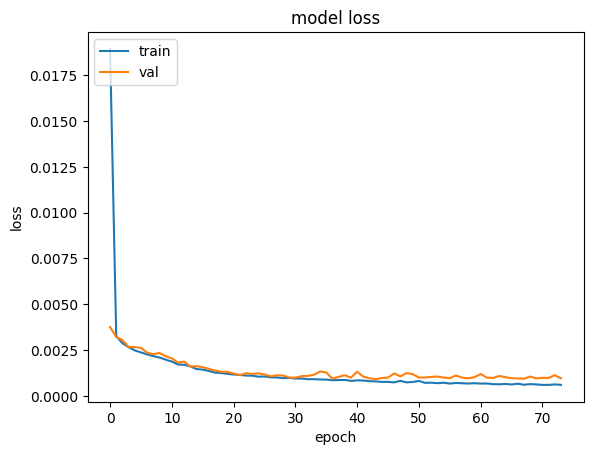

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')



In [ ]:
X_enc_test, X_dec_test, y_test = create_seq2seq_data(test_scaled,sequence_length, num_prediction)

X_enc_test = np.transpose(X_enc_test, (0, 2, 1))
X_dec_test = np.transpose(X_dec_test, (0, 2, 1))
y_test = np.expand_dims(y_test, axis=2)
y_test = np.transpose(y_test, (0, 2, 1))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
import numpy as np


y_pred = model.predict([X_enc_test, X_dec_test])

print(y_pred.shape)

204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
(6497, 1, 24)


In [ ]:
X2D= y_pred.squeeze()
X2D.shape

(6497, 24)

In [ ]:
y_pred_inverse = []
for i in range(X2D.shape[1]):
    cols_to_inverse = X2D[:, i].reshape(-1, 1)
    cols_inverse = scaler.inverse_transform(np.repeat(cols_to_inverse, 9, axis=1))
    y_pred_inverse.append(cols_inverse[:, 0])

# Merge the inverse transformed columns
y_pred_merged = np.column_stack(y_pred_inverse)

print(y_pred_merged.shape)

(6497, 24)


In [ ]:
X2D_test= y_test.squeeze()
X2D_test.shape

(6497, 24)

In [ ]:
y_test_inverse = []
for i in range(X2D_test.shape[1]):
    cols_to_inverse = X2D_test[:, i].reshape(-1, 1)
    cols_inverse = scaler.inverse_transform(np.repeat(cols_to_inverse, 9, axis=1))
    y_test_inverse.append(cols_inverse[:, 0])

# Merge the inverse transformed columns
y_test_merged = np.column_stack(y_test_inverse)

print(y_test_merged.shape)

(6497, 24)


In [ ]:
y_test_inv = y_test_merged
y_pred_inv= y_pred_merged

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.9f' % rmse)


# calculate MAE
from sklearn.metrics import mean_absolute_error
mae= mean_absolute_error(y_test_inv, y_pred_inv)
print('Test MAE: %.9f' % mae)


# calculate MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape= mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('Test MAPE: %.9f' % mape)

# calculate NRMSE
actual_test=y_test_inv
Nrmse_test=rmse /(actual_test.max() - actual_test.min())
print('Test NRMSE: %.9f' % Nrmse_test)


from sklearn.metrics import r2_score
r2 = r2_score(y_test_inv, y_pred_inv)
print('R2 score: %.9f' % r2)


Test RMSE: 23.346145066
Test MAE: 13.392093299
Test MAPE: 0.027102613
Test NRMSE: 0.044865737
R2 score: 0.966661596


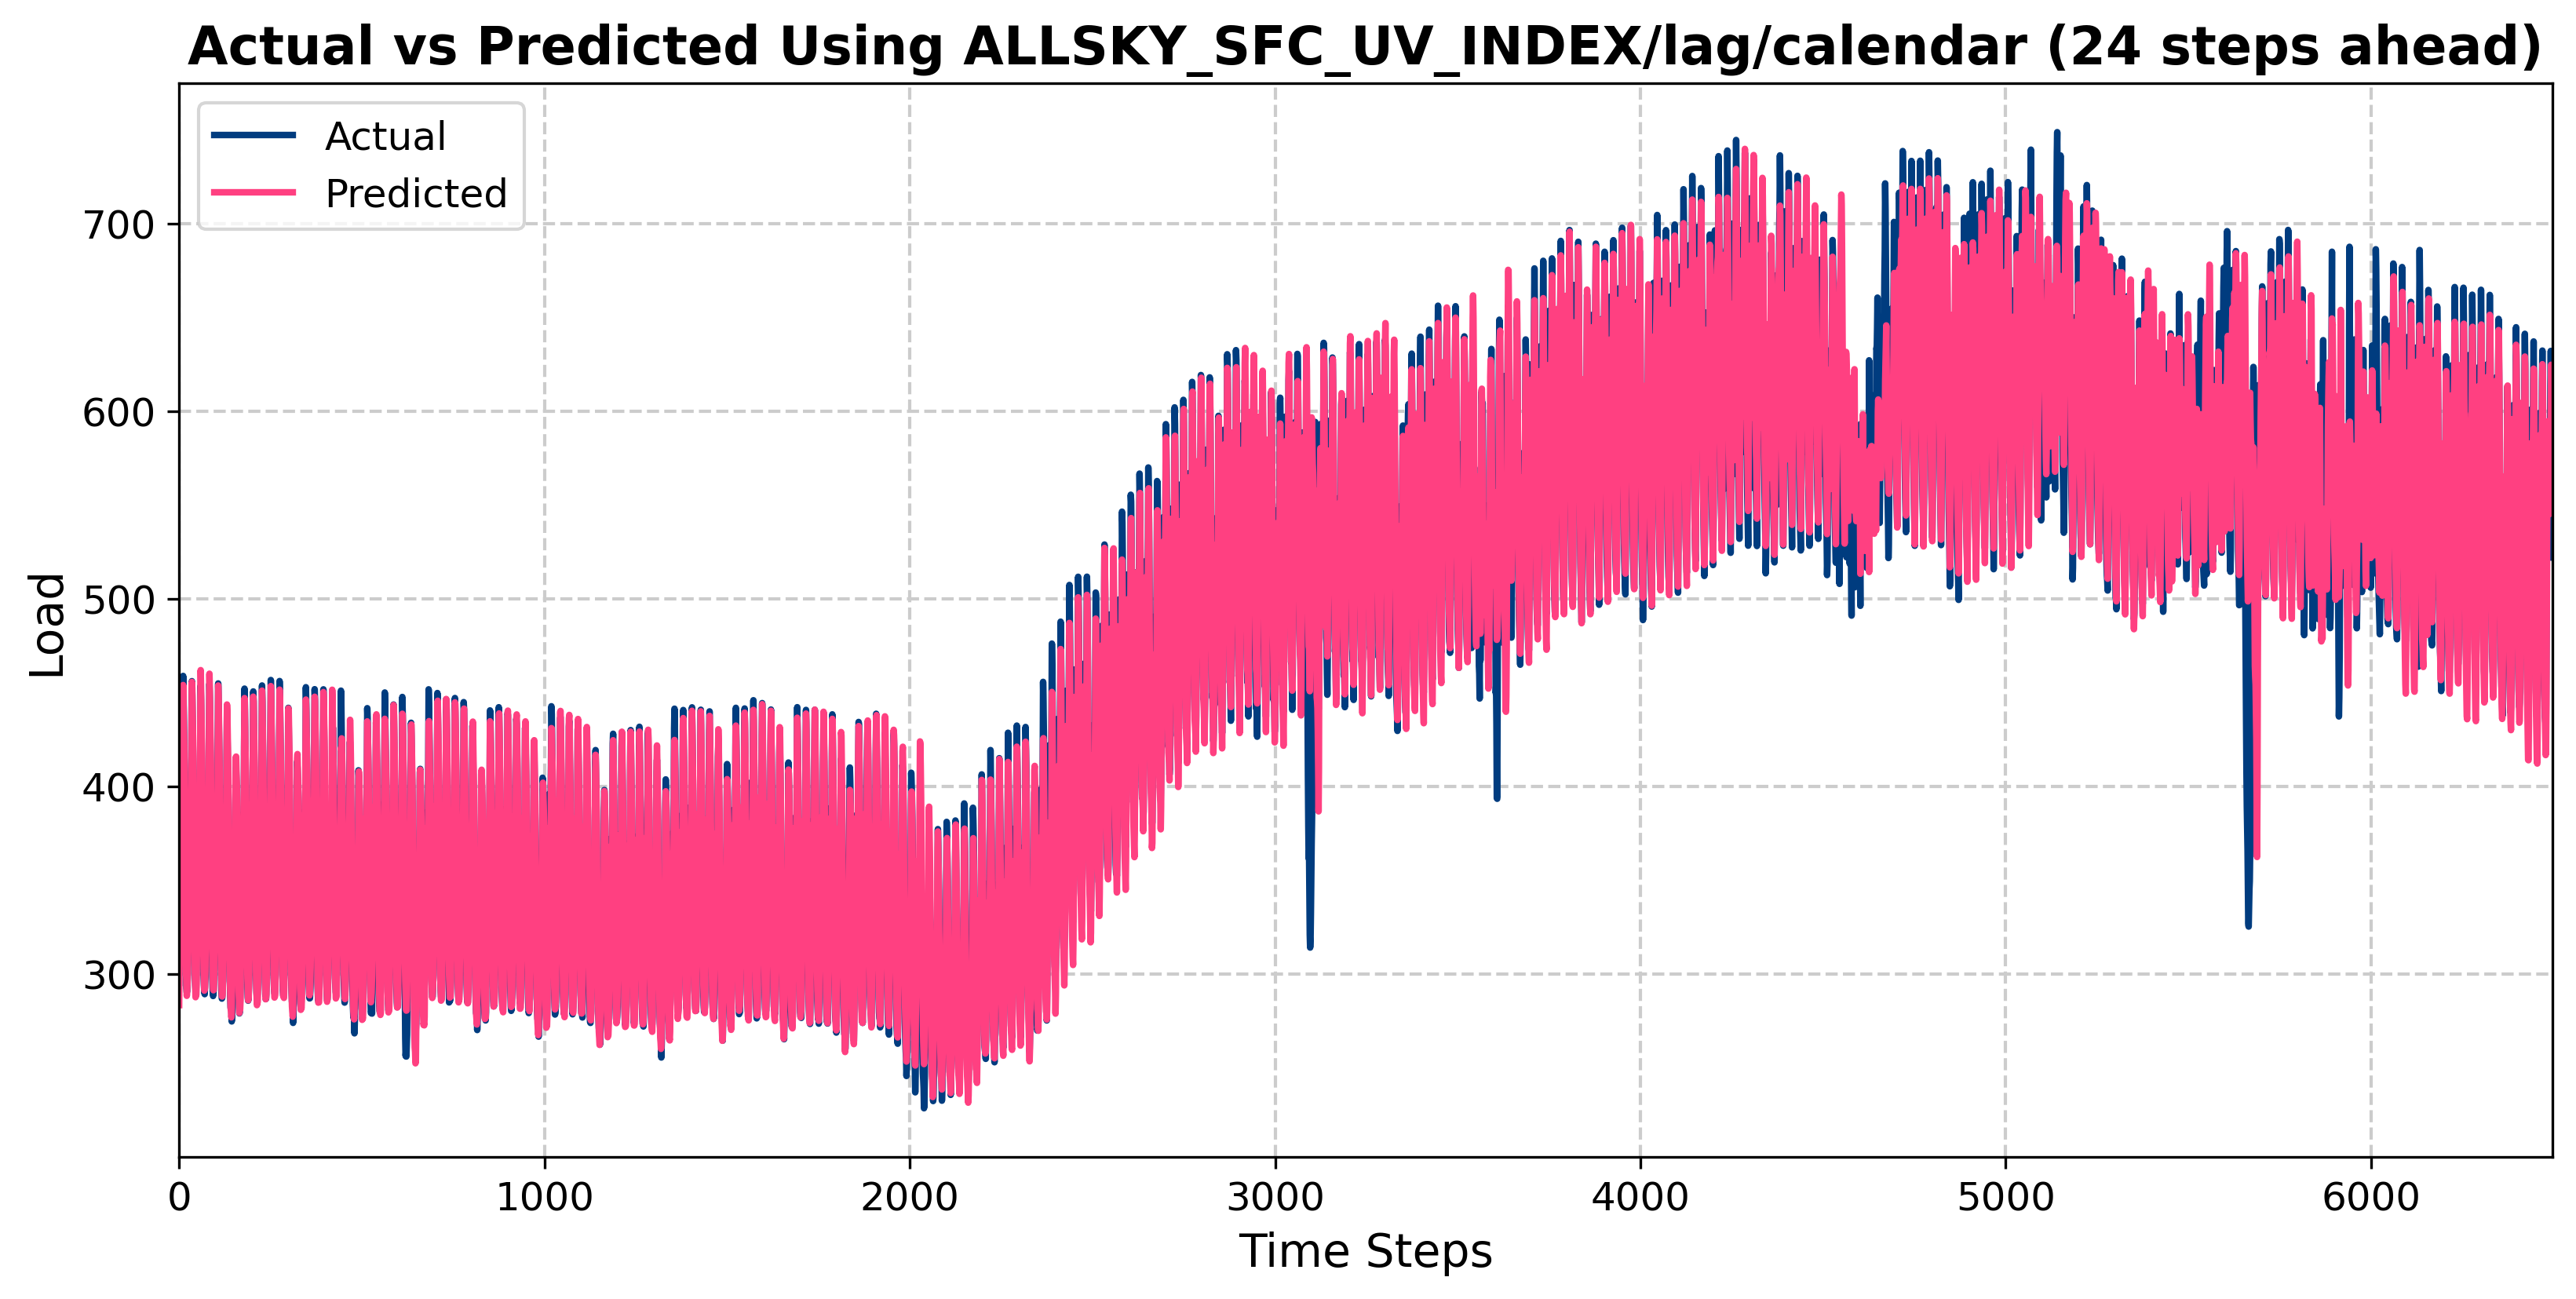

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the variables y_test_inv and y_pred_inv
# Take the last value from each sample
y_test_agg = y_test_inv[:, -1]
y_pred_agg = y_pred_inv[:, -1]

x = np.arange(y_test_inv.shape[0])

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Plot the actual values
ax.plot(x, y_test_agg, label='Actual', color='#003C7F', linewidth=2)

# Plot the predicted values
ax.plot(x, y_pred_agg, label='Predicted', color='#FF4081', linewidth=2)

# Set the axis labels and title
ax.set_xlabel('Time Steps', fontsize=14)
ax.set_ylabel('Load', fontsize=14)
ax.set_title('Actual vs Predicted Using ALLSKY_SFC_UV_INDEX/lag/calendar (24 steps ahead)', fontsize=16, fontweight='bold')

# Set the x-axis limits
ax.set_xlim(0, y_test_inv.shape[0])

# Add a legend
ax.legend(loc='upper left', fontsize=12)

# Adjust the x-axis ticks to show every 1000 values
ax.set_xticks(np.arange(0, 6497, 1000))
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the grid
ax.grid(True, color='#cccccc', linestyle='--', linewidth=1)

# Adjust the overall layout
plt.subplots_adjust(top=0.88, bottom=0.12, left=0.08, right=0.92, hspace=0.2, wspace=0.2)

# Save the figure
plt.savefig('24   ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

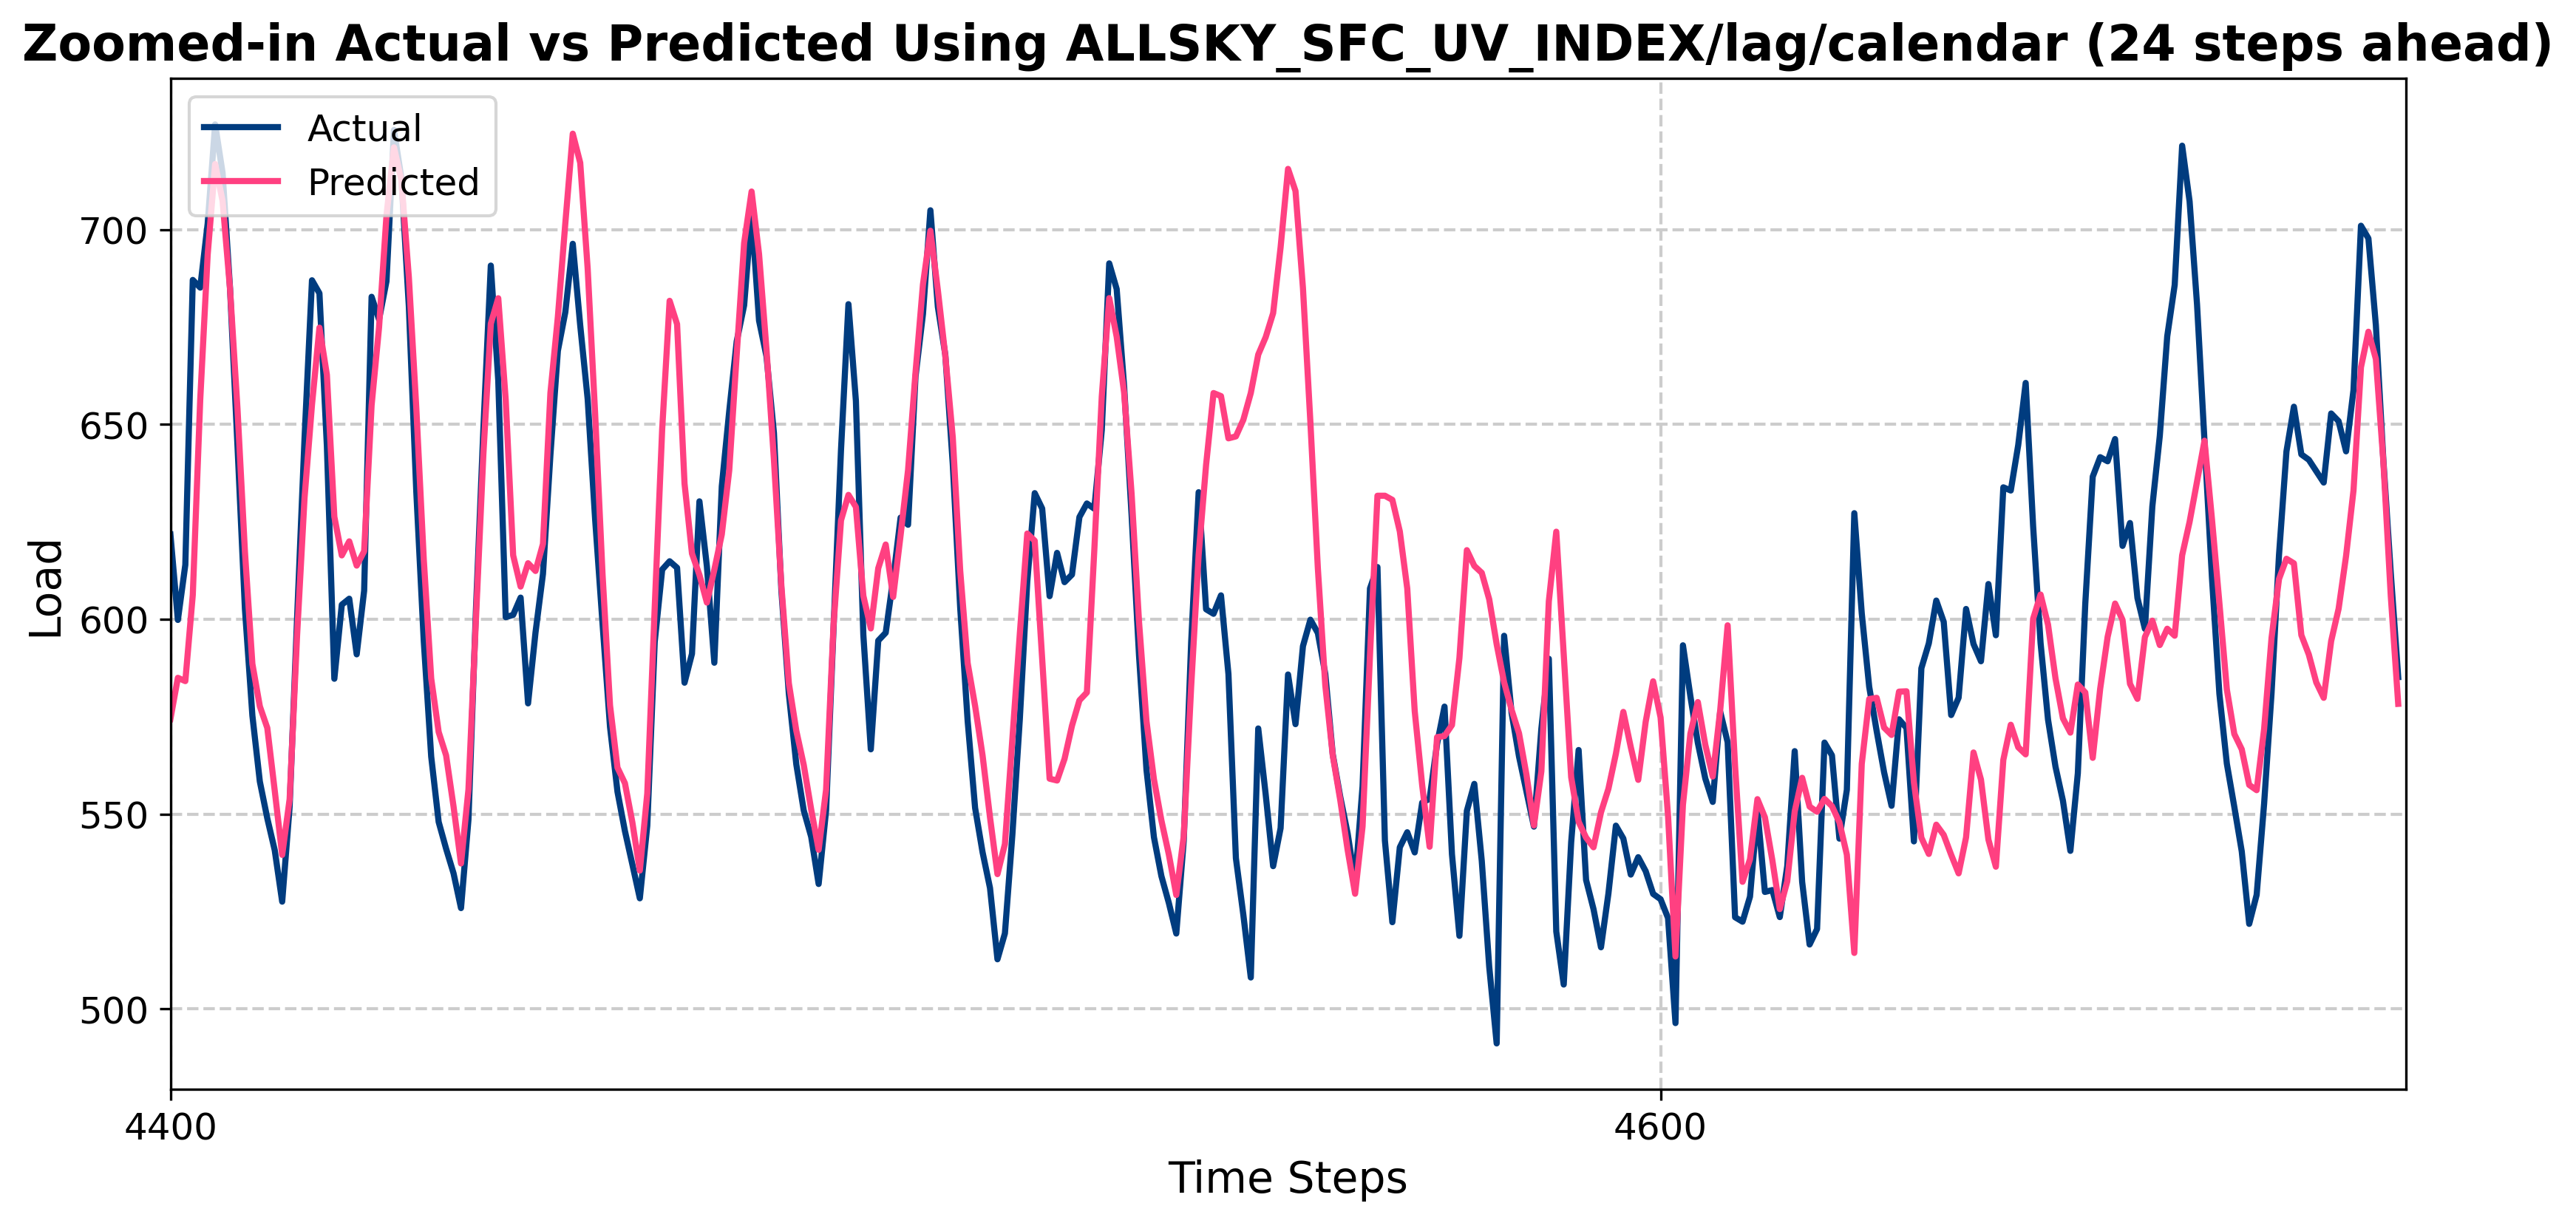

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the variables y_test_inv and y_pred_inv
# Take the last value from each sample
y_test_agg = y_test_inv[:, -1]
y_pred_agg = y_pred_inv[:, -1]

x = np.arange(y_test_inv.shape[0])

# Step 1: Identify the range of values on the x-axis to zoom in on
start_idx = 4400
end_idx = 4700

# Step 2: Create a new figure and axes object
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Step 3: Plot the desired range of data on the new axes
ax.plot(x[start_idx:end_idx], y_test_agg[start_idx:end_idx], label='Actual', color='#003C7F', linewidth=2)
ax.plot(x[start_idx:end_idx], y_pred_agg[start_idx:end_idx], label='Predicted', color='#FF4081', linewidth=2)

# Step 4: Customize the new plot
ax.set_xlabel('Time Steps', fontsize=14)
ax.set_ylabel('Load', fontsize=14)
ax.set_title('Zoomed-in Actual vs Predicted Using ALLSKY_SFC_UV_INDEX/lag/calendar (24 steps ahead)', fontsize=16, fontweight='bold')
ax.set_xlim(start_idx, end_idx)
ax.legend(loc='upper left', fontsize=12)

# Adjust the x-axis ticks to show every 200 values
ax.set_xticks(np.arange(start_idx, end_idx, 200))
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the grid
ax.grid(True, color='#cccccc', linestyle='--', linewidth=1)

# Adjust the overall layout
plt.subplots_adjust(top=0.88, bottom=0.12, left=0.08, right=0.92, hspace=0.2, wspace=0.2)

# Save the figure
plt.savefig('zoomed_24   ALLSKY_SFC_UV_INDEX  multihead+callagBO+IMP.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()